In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import sklearn
#from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
pd.set_option('display.max_columns', None)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import multiprocessing
import scipy
from sklearn.model_selection import KFold

In [2]:
x_data = pd.read_excel("All features.xlsx")
x_data

,c1nc[nH]n1,c1c[nH]cn1,c1cc[nH]c1,c1ccncc1,c1ccc2[nH]ccc2c1,c1ccc2scnc2c1,c1ccc2cc3ccccc3cc2c1,c1cscn1,c1ccsc1,c1cn[nH]c1,c1ccc2occcc2c1,c1cc2ccc(ccnccc3ccc(ccn1)[nH]3)[nH]2,c1ccccc1,c1nnn[nH]1,c1ccc2sc[n+]c2c1,c1ccc2ncccc2c1,c1nncs1,Alkene,Alkylchloride,Alkylfluoride,Alkylbromide,Trifluoromethyl,Alcohol,Althoxyl,Primary_aliph_amine,Secondary_aliph_amine,Tertiary_aliph_amine,Primary_arom_amine,Secondary_arom_amine,Tertiary_arom_amine,Alkylthiol,Dialkylthioether,Disulfide,Aldehyde,Ketone,Oxime,Acetal,Hemiacetal,Thioacetal,Chloroalkene,Bromoalkene,Enol,Carboxylic_acid,Carboxylic_ester,Lactone,Amide,Lactam,Nitrile,Thiourea,Phenol,Arylchloride,Arylfluoride,Arylbromide,Aryliodide,Arylthiol,Oxoarene,Azo,Nitro,Sulfon,Sulfonic_derivative,Phosphonic_acid_derivative,Tri_boron,Sugar_pattern_combi,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,TPSA,EState_VSA1,EState_VSA10,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,Num of Conju-Strut,Num of Conju-All-Atoms,Atom Num Conju-All Ratio,AtomWt Conju-All Ratio,Full-Mol Wiener Index,Individual Conju-Atom Number (Max-Conju),Conju-Part-Wt (Max-Conju),Conju-AtomicWt (Max-Conju),Max Conju-Distance (Max-Conju),Conju-Branch Index (Max-Conju),Conju-Strut Wiener Index (Max-Conju),Atom_PEOE-Charge_Sum,Atom_LogP_Sum,Atom_MR_Sum,Atom_PEOE-Charge_Mean,Atom_LogP_Mean,Atom_MR_Mean,Atom_PEOE-Charge_Std,Atom_LogP_Std,Atom_MR_Std,Atom_PEOE-Charge_Max,Atom_LogP_Max,Atom_MR_Max,Atom_PEOE-Charge_Min,Atom_LogP_Min,Atom_MR_Min,Atom_PEOE-Charge_Delta,Atom_LogP_Delta,Atom_MR_Delta,Fun_PEOE-Charge_Sum,Fun_LogP_Sum,Fun_MR_Sum,Fun_PEOE-Charge_Mean,Fun_LogP_Mean,Fun_MR_Mean,Fun_PEOE-Charge_Std,Fun_LogP_Std,Fun_MR_Std,Fun_PEOE-Charge_Max,Fun_LogP_Max,Fun_MR_Max,Fun_PEOE-Charge_Min,Fun_LogP_Min,Fun_MR_Min,Fun_PEOE-Charge_Delta,Fun_LogP_Delta,Fun_MR_Delta,Mid-Fun_PEOE-Charge_Sum,Mid-Fun_LogP_Sum,Mid-Fun_MR_Sum,Mid-Fun_PEOE-Charge_Mean,Mid-Fun_LogP_Mean,Mid-Fun_MR_Mean,Mid-Fun_PEOE-Charge_Std,Mid-Fun_LogP_Std,Mid-Fun_MR_Std,Mid-Fun_PEOE-Charge_Max,Mid-Fun_LogP_Max,Mid-Fun_MR_Max,Mid-Fun_PEOE-Charge_Min,Mid-Fun_LogP_Min,Mid-Fun_MR_Min,Mid-Fun_PEOE-Charge_Delta,Mid-Fun_LogP_Delta,Mid-Fun_MR_Delta,Conju_PEOE-Charge_Sum,Conju_LogP_Sum,Conju_MR_Sum,Conju_PEOE-Charge_Mean,Conju_LogP_Mean,Conju_MR_Mean,Conju_PEOE-Charge_Std,Conju_LogP_Std,Conju_MR_Std,Conju_PEOE-Charge_Max,Conju_LogP_Max,Conju_MR_Max,Conju_PEOE-Charge_Min,Conju_LogP_Min,Conju_MR_Min,Conju_PEOE-Charge_Delta,Conju_LogP_Delta,Conju_MR_Delta,Atom Number,Occupied Orbitals,Molecule Weight,HOMO,LUMO,HOMO-LUMO Gap,Farthest Distance,Molecular Radius,Molecular Size Short,Molecular Size Medium,Molecular Size Long,Long/Sum Size Ratio,Length/Diameter,MPP,SDP,Dipole Moment (a.u.),Quadrupole Moment,Octopole Moment,ODI LUMO+1,ODI LUMO,ODI HOMO,ODI HOMO-1,ODI Mean,ODI Std,Isosurface area,Sphericity,Volume (Angstrom^3),Density (g/cm^3),LEAE Minimal Value,LEAE Maximal Value,Surfac

In [3]:
y_data = pd.read_csv("Target.csv", usecols=[0])
y_data

,FEaverage H2
0,35.995845
1,21.431834
2,30.293880
3,18.986892
4,15.947978
...,...
77,24.887160
78,18.470878
79,26.780786
80,25.205839


In [4]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
x_data.columns = [regex.sub("_", col) if any(i in str(col) for i in set(('[', ']', '<'))) 
                        else col for col in x_data.columns.values]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=0)

In [5]:
scaler1 = preprocessing.MinMaxScaler().fit(x_train)  
scaler2 = preprocessing.MinMaxScaler().fit(y_train)

x_train = scaler1.transform(x_train)
x_test = scaler1.transform(x_test)

y_train = scaler2.transform(y_train)
y_test = scaler2.transform(y_test)

In [6]:
num_cores = multiprocessing.cpu_count()

In [7]:
kf = KFold(n_splits=10, random_state=0, shuffle=True) 

variate=list(range(x_train.shape[1]))   
selected=[]   
train_mse_list = []
val_mse_list = []

current_score,best_new_score=float('inf'),float('inf')  

    
# def my_custom_loss_func(y, y_predict):
#     error = 0
#     for i in range(0, y.shape[1]):
#         error += mean_squared_error(y[:, i], y_predict[:, i])
#     error = error / y.shape[1]
#     return error

# my_scorer = make_scorer(my_custom_loss_func, greater_is_better=False)


while variate:
    mse_with_variate_train = []
    mse_with_variate_val=[]
    for i in variate:  
        current_variate = selected+[i]  
        current_x_train = x_train[:, current_variate]   
        current_x_test = x_test[:, current_variate]   
        
        train_mse_list_ = []
        val_mse_list_ = []
        
        for train_index, val_index in kf.split(current_x_train, y_train):
            x_train_ = current_x_train[train_index, :]
            x_val_ = current_x_train[val_index, :]
            y_train_ = y_train[train_index, :]
            y_val_ = y_train[val_index, :]
            
            #model = MLPRegressor(random_state=0,early_stopping=True,alpha=0.0001,hidden_layer_sizes=(1,),learning_rate_init=0.01,
            #                    max_iter=5000,n_iter_no_change=100)
            svr = SVR(kernel='rbf')
            multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
            multioutput_svr.fit(x_train_, y_train_)
        
            train_pre = multioutput_svr.predict(x_train_)
            val_pre = multioutput_svr.predict(x_val_)
            
            train_mse_ = mean_squared_error(y_train_, train_pre)
    
            val_mse_ = mean_squared_error(y_val_, val_pre)
    
            train_mse_list_.append(train_mse_)
    
            val_mse_list_.append(val_mse_)
            
        train_mse = np.mean(train_mse_list_)
        
        val_mse = np.mean(val_mse_list_)
        
        mse_with_variate_train.append((train_mse,i))
        
        mse_with_variate_val.append((val_mse,i))
            
    min_mse_index = mse_with_variate_val.index(min(mse_with_variate_val))
    best_new_score,best_candidate_index = mse_with_variate_val[min_mse_index]
    train_new_score,_ = mse_with_variate_train[min_mse_index]
        
    variate.remove(best_candidate_index)  
    selected.append(best_candidate_index)  
    
    train_mse_list.append(mse_with_variate_train[min_mse_index][0])
    
    val_mse_list.append(mse_with_variate_val[min_mse_index][0])


In [8]:
selected

[218,
 306,
 145,
 279,
 296,
 263,
 201,
 101,
 217,
 99,
 216,
 58,
 247,
 133,
 105,
 273,
 147,
 29,
 51,
 197,
 243,
 246,
 237,
 219,
 269,
 129,
 202,
 102,
 42,
 184,
 225,
 234,
 238,
 96,
 17,
 304,
 242,
 135,
 123,
 27,
 226,
 7,
 196,
 52,
 22,
 61,
 5,
 244,
 268,
 152,
 187,
 130,
 118,
 125,
 249,
 143,
 251,
 23,
 0,
 1,
 19,
 240,
 46,
 2,
 4,
 6,
 180,
 9,
 11,
 139,
 13,
 154,
 151,
 15,
 16,
 18,
 20,
 21,
 26,
 33,
 35,
 36,
 37,
 39,
 40,
 10,
 41,
 43,
 47,
 53,
 56,
 60,
 62,
 57,
 110,
 183,
 14,
 25,
 45,
 44,
 241,
 55,
 128,
 160,
 121,
 59,
 98,
 28,
 112,
 117,
 295,
 250,
 94,
 170,
 127,
 38,
 258,
 262,
 91,
 259,
 161,
 164,
 24,
 153,
 114,
 113,
 198,
 236,
 162,
 299,
 163,
 92,
 155,
 90,
 108,
 95,
 77,
 165,
 116,
 193,
 173,
 122,
 255,
 144,
 200,
 167,
 48,
 76,
 181,
 252,
 70,
 282,
 136,
 276,
 68,
 235,
 277,
 69,
 290,
 150,
 67,
 278,
 254,
 253,
 66,
 220,
 109,
 159,
 228,
 221,
 78,
 141,
 93,
 80,
 168,
 305,
 289,
 75,
 245,
 79,
 

In [9]:
train_mse_list

[0.01945956229780847,
 0.015869378413928173,
 0.014225996254754198,
 0.013458626170837035,
 0.013038530834552062,
 0.013346816496140852,
 0.013436401478988377,
 0.013750836188049467,
 0.013814212449864971,
 0.013976151964640107,
 0.014099284053512323,
 0.014414771699764873,
 0.014177877771706699,
 0.011395017413391769,
 0.010931702178063317,
 0.010700417360643165,
 0.0104509349246121,
 0.010584261796929001,
 0.010687470585831452,
 0.010966710371624059,
 0.010997471638650053,
 0.01106453032233793,
 0.011160102229920966,
 0.011027120174035905,
 0.010960423170593175,
 0.011074295233891003,
 0.011068554205868589,
 0.011071895030053559,
 0.011215328883515945,
 0.011261253938587835,
 0.011064660242536314,
 0.011136192134047993,
 0.011194026541526151,
 0.011246354010100905,
 0.011312099669782787,
 0.01133236212944251,
 0.011379428742597775,
 0.010181245207251149,
 0.009678367368231286,
 0.008732546408053186,
 0.008660519259819444,
 0.008901170779273274,
 0.008831495368372688,
 0.0088972394079

In [10]:
val_mse_list

[0.019671691460523888,
 0.01791944594289597,
 0.016596150681656187,
 0.01637706967814357,
 0.016486059910231728,
 0.016351436477833024,
 0.01664430186950515,
 0.01690961532860011,
 0.017041464202735015,
 0.017160364402308167,
 0.017335135247666292,
 0.017439147866600703,
 0.017257940139394655,
 0.016577889478609834,
 0.01551364832658283,
 0.015078224605233356,
 0.014735699725979828,
 0.014315892882940034,
 0.01422470551402199,
 0.014183397588998817,
 0.014187931941406103,
 0.014206794947582058,
 0.014236281979175808,
 0.014287235689357216,
 0.01434720170203298,
 0.014392438467944533,
 0.014434299629435671,
 0.014488046787388154,
 0.01455908521856177,
 0.014580778659991587,
 0.01448438323496457,
 0.014531751121003864,
 0.014576346075927513,
 0.01463482328290303,
 0.014690498100565033,
 0.014734758242300694,
 0.014800833144479403,
 0.014721095105086346,
 0.014301342458254932,
 0.013603322905075071,
 0.013584983099770515,
 0.013592055904295793,
 0.013616882337635338,
 0.013636995796347837

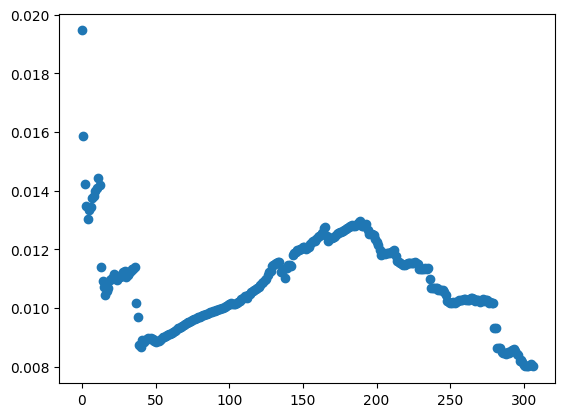

In [11]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

plt.scatter(range(len(train_mse_list)), train_mse_list)
plt.show()

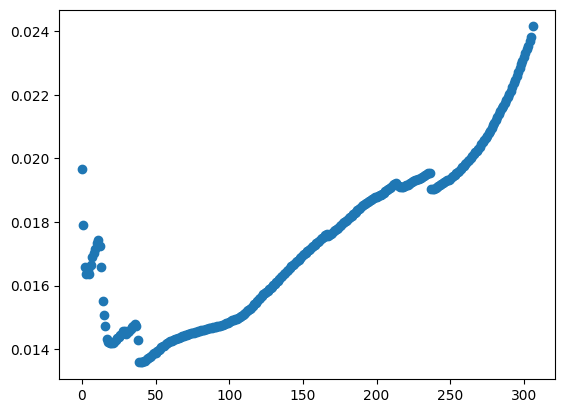

In [12]:
plt.scatter(range(len(val_mse_list)), val_mse_list)
plt.show()

In [7]:

min_index  = val_mse_list.index(min(val_mse_list))
min_value = val_mse_list[min_index]
print(min_index)
print(min_value)

40
0.013584983099770515


In [9]:
selected_columns = x_data.columns[selected[:min_index+1]].tolist()
for col in selected_columns:
    print(col)

Mid-Fun_MR_Sum
Iaverage / mA cm-2
VSA_EState6
Density (g/cm^3)
ALIE Variance
Long/Sum Size Ratio
Fun_PEOE-Charge_Mean
PEOE_VSA3
Mid-Fun_LogP_Sum
PEOE_VSA14
Mid-Fun_PEOE-Charge_Sum
Sulfon
Conju_LogP_Min
EState_VSA4
PEOE_VSA7
ODI HOMO-1
VSA_EState8
Tertiary_arom_amine
Arylfluoride
Atom_MR_Delta
Conju_PEOE-Charge_Max
Conju_PEOE-Charge_Min
Conju_PEOE-Charge_Mean
Mid-Fun_PEOE-Charge_Mean
Octopole Moment
EState_VSA1
Fun_LogP_Mean
PEOE_VSA4
Carboxylic_acid
Atom_LogP_Mean
Mid-Fun_PEOE-Charge_Max
Conju_PEOE-Charge_Sum
Conju_LogP_Mean
PEOE_VSA11
Alkene
Atom1_ALIE Min value
Conju_MR_Std
EState_VSA6
SlogP_VSA4
Primary_arom_amine
Mid-Fun_LogP_Max


In [16]:
#col_index = [sorted_index[i] for i in selected[:min_index+1]]

import os
save_dir = 'Selected features'
os.makedirs(save_dir, exist_ok=True)  
data = x_data[selected_columns]

output_file = os.path.join(save_dir, "selected_features-H2.csv")
data.to_csv(output_file, index=False, encoding='utf_8_sig')
data

,Mid-Fun_MR_Sum,Iaverage / mA cm-2,VSA_EState6,Density (g/cm^3),ALIE Variance,Long/Sum Size Ratio,Fun_PEOE-Charge_Mean,PEOE_VSA3,Mid-Fun_LogP_Sum,PEOE_VSA14,Mid-Fun_PEOE-Charge_Sum,Sulfon,Conju_LogP_Min,EState_VSA4,PEOE_VSA7,ODI HOMO-1,VSA_EState8,Tertiary_arom_amine,Arylfluoride,Atom_MR_Delta,Conju_PEOE-Charge_Max,Conju_PEOE-Charge_Min,Conju_PEOE-Charge_Mean,Mid-Fun_PEOE-Charge_Mean,Octopole Moment,EState_VSA1,Fun_LogP_Mean,PEOE_VSA4,Carboxylic_acid,Atom_LogP_Mean,Mid-Fun_PEOE-Charge_Max,Conju_PEOE-Charge_Sum,Conju_LogP_Mean,PEOE_VSA11,Alkene,Atom1_ALIE Min value,Conju_MR_Std,EState_VSA6,SlogP_VSA4,Primary_arom_amine,Mid-Fun_LogP_Max
0,91.1300,142.333333,3.118889,2.9520,2.07005,0.491618,1.241938e-01,0.0,1.2404,7.118392,7.436550e-01,0,0.6122,11.336786,12.990104,11.37,1.443818,0,0,6.4695,-1.259678e-01,-1.259678e-01,-1.259678e-01,2.478850e-01,141.3395,7.118392,0.077133,0.000000,0,-0.020528,4.970415e-01,-1.259678e-01,0.6122,5.783245,0,9.858382,0.0,6.066367,0.0,0,0.6122
1,32.0190,133.000000,4.027199,4.2813,1.76789,0.449793,-2.780000e-17,0.0,2.5106,0.000000,-4.160000e-17,0,2.5106,0.000000,27.376374,37.38,0.000000,0,0,7.8700,-4.160000e-17,-4.160000e-17,-4.160000e-17,-4.160000e-17,49.2643,0.000000,1.255300,0.000000,0,0.278956,-4.160000e-17,-4.160000e-17,2.5106,0.000000,0,9.734129,0.0,11.336786,0.0,0,2.5106
2,16.6218,134.666667,0.000000,3.1136,3.09355,0.399801,-9.395815e-02,0.0,-0.0417,5.969305,-1.879163e-01,0,-0.4222,0.000000,0.000000,31.65,0.000000,0,0,7.5910,-1.231819e-01,-1.231819e-01,-1.231819e-01,-9.395815e-02,27.9638,5.969305,-0.020850,12.628789,1,0.000089,-6.473444e-02,-1.231819e-01,-0.4222,0.000000,0,8.768344,0.0,0.000000,0.0,0,0.3805
3,30.4536,107.333333,0.000000,3.0179,3.15466,0.483168,-1.515180e-01,0.0,0.4520,11.938611,-4.545539e-01,0,-0.4222,0.000000,0.000000,24.50,0.000000,0,0,7.5910,-1.337200e-01,-1.337200e-01,-1.337200e-01,-1.515180e-01,596.5079,11.938611,0.150667,0.000000,2,0.059873,-1.337200e-01,-2.674400e-01,-0.4222,0.000000,0,8.509234,0.0,0.000000,0.0,0,1.2964
4,20.3940,88.000000,0.000000,2.4212,2.11599,0.527381,-1.928926e-02,0.0,1.3584,0.000000,-3.857851e-02,0,0.6792,11.505707,0.000000,12.60,7.154722,0,0,6.5340,-1.928926e-02,-1.928926e-02,-1.928926e-02,-1.928926e-02,67.3000,0.000000,0.679200,11.761885,0,0.123035,-1.928926e-02,-3.857851e-02,0.6792,0.000000,2,7.853093,0.0,0.000000,0.0,0,0.6792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,17.9720,85.333333,0.000000,2.3575,1.89496,0.660614,-7.716095e-02,0.0,0.7610,0.000000,-1.543219e-01,0,0.0000,11.505707,24.347350,28.47,0.000000,0,0,6.5340,0.000000e+00,0.000000e+00,0.000000e+00,-7.716095e-02,529.6783,0.000000,0.380500,25.257578,0,0.116671,-7.716095e-02,0.000000e+00,0.0000,0.000000,0,8.026730,0.0,0.000000,0.0,0,0.3805
78,17.9720,108.333333,0.000000,2.4114,2.04432,0.625620,-7.716095e-02,0.0,0.7610,0.000000,-1.543219e-01,0,0.0000,11.505707,24.347350,27.77,0.000000,0,0,6.5340,0.000000e+00,0.000000e+00,0.000000e+00,-7.716095e-02,379.8979,0.000000,0.380500,25.257578,0,0.113807,-7.716095e-02,0.000000e+00,0.0000,0.000000,0,8.027367,0.0,0.000000,0.0,0,0.3805
79,17.9720,83.666667,0.000000,2.5436,2.39650,0.569067,-7.716095e-02,0.0,0.7610,0.000000,-1.543219e-01,0,0.0000,11.505707,24.347350,26.18,0.000000,0,0,6.5340,0.000000e+00,0.000000e+00,0.000000e+00,-7.716095e-02,185.4900,0.000000,0.380500,25.257578,0,0.106121,-7.716095e-02,0.000000e+00,0.0000,0.000000,0,8.035676,0.0,0.000000,0.0,0,0.3805
80,17.9720,97.666667,0.000000,2.6128,2.56750,0.530080,-7.716043e-02,0.0,0.7610,0.000000,-1.543209e-01,0,0.0000,11.505707,24.347350,15.69,0.000000,0,0,6.5340,0.000000e+00,0.000000e+00,0.000000e+00,-7.716043e-02,153.0647,0.000000,0.380500,25.257578,0,0.101638,-7.716043e-02,0.000000e+00,0.0000,0.000000,0,8.049127,0.0,0.000000,0.0,0,0.3805


In [10]:
from sklearn.metrics import mean_squared_error, r2_score

min_val_mse_index=min_index
final_x_train = x_train[:, selected[:min_val_mse_index+1]]
final_x_test = x_test[:, selected[:min_val_mse_index+1]]

svr = SVR(kernel='rbf')
multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
multioutput_svr.fit(final_x_train, y_train)

test_pred = multioutput_svr.predict(final_x_test)
test_mse = mean_squared_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

test_mse = round(test_mse, 4)
test_r2 = round(test_r2, 4)

print(f"Selected variables based on validation MSE: {selected_columns}")
print(f"Test MSE: {test_mse}")
print(f"Test R2: {test_r2}")

import os
save_dir = 'Test mse after svr'
os.makedirs(save_dir, exist_ok=True) 
output_file1 = os.path.join(save_dir, "final_evaluation-H2.csv")

df_summary = pd.DataFrame({
    'Selected Variables': [selected_columns],
    'Final Test MSE': [test_mse],
    'Final Test R2': [test_r2]
})
df_summary.to_csv(output_file1, index=False)

print(f"Results saved to '{output_file1}'")

Selected variables based on validation MSE: ['Mid-Fun_MR_Sum', 'Iaverage / mA cm-2', 'VSA_EState6', 'Density (g/cm^3)', 'ALIE Variance', 'Long/Sum Size Ratio', 'Fun_PEOE-Charge_Mean', 'PEOE_VSA3', 'Mid-Fun_LogP_Sum', 'PEOE_VSA14', 'Mid-Fun_PEOE-Charge_Sum', 'Sulfon', 'Conju_LogP_Min', 'EState_VSA4', 'PEOE_VSA7', 'ODI HOMO-1', 'VSA_EState8', 'Tertiary_arom_amine', 'Arylfluoride', 'Atom_MR_Delta', 'Conju_PEOE-Charge_Max', 'Conju_PEOE-Charge_Min', 'Conju_PEOE-Charge_Mean', 'Mid-Fun_PEOE-Charge_Mean', 'Octopole Moment', 'EState_VSA1', 'Fun_LogP_Mean', 'PEOE_VSA4', 'Carboxylic_acid', 'Atom_LogP_Mean', 'Mid-Fun_PEOE-Charge_Max', 'Conju_PEOE-Charge_Sum', 'Conju_LogP_Mean', 'PEOE_VSA11', 'Alkene', 'Atom1_ALIE Min value', 'Conju_MR_Std', 'EState_VSA6', 'SlogP_VSA4', 'Primary_arom_amine', 'Mid-Fun_LogP_Max']
Test MSE: 0.0258
Test R2: -0.7555
Results saved to 'Test mse after svr/final_evaluation-H2.csv'
